## Calidad de vinos (Clasificacion multiclase)

In [275]:
# Se requiere Python ≥ 3.5
import sys;
assert sys.version_info >= (3, 5);

# Se requiere Scikit-Learn ≥ 0.20
import sklearn;
assert sklearn.__version__ >= "0.20";
from sklearn.svm import SVC;
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.naive_bayes import GaussianNB 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict;
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix;
from sklearn.metrics import ConfusionMatrixDisplay;
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve;
from sklearn.metrics import roc_auc_score;
from sklearn.utils import resample

import numpy as np;
import pandas as pd
from pandas.plotting import scatter_matrix
import xgboost as xgb 

import os;
import matplotlib as mpl;
import seaborn as sns;
import matplotlib.pyplot as plt;
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
mpl.rc('axes',  labelsize=14);
mpl.rc('xtick', labelsize=12);
mpl.rc('ytick', labelsize=12);



### Primer contacto con los datos

In [276]:
wines = pd.read_csv("./datasets/winequality-red.csv")
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [277]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [278]:
wines.isna().sum()


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [279]:
wines.duplicated().sum()

240

- No hay valores nulos.
- No tenemos ninguna columna categorica.
- No tenemos valores NaN.

- En la siguiente grafica vemos que la calidad de los vinos se concentra en los valores 5 y 6.


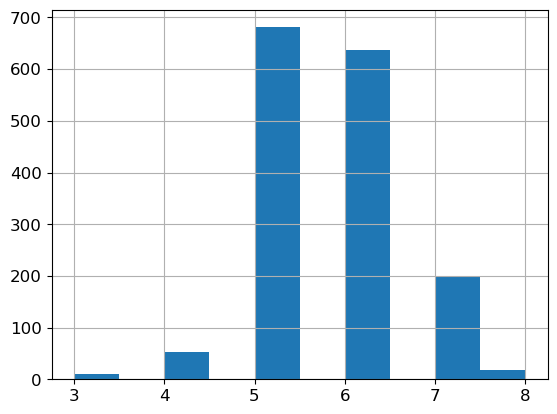

In [280]:
wines['quality'].hist();

- Con estos datos, nuestros modelos solo van a predecir (en su mayoria) vinos de calidad 5 o 6 (TP y FP). Por lo tanto deberemos generar mas muestras de las demas calidades.

In [281]:
wines['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

- Utilizaremos la tecnica del sobremuestreo para balancear la columna de calidad

In [282]:
q3 = wines[wines.quality==3]               
q4 = wines[wines.quality==4]               
q5 = wines[wines.quality==5]     
q6 = wines[wines.quality==6]     
q7 = wines[wines.quality==7]     
q8 = wines[wines.quality==8]     

In [283]:
q3_new = resample(q3, replace=True, n_samples=600, random_state=42) 
q4_new = resample(q4, replace=True, n_samples=600, random_state=42) 
q7_new = resample(q7, replace=True, n_samples=600, random_state=42) 
q8_new = resample(q8, replace=True, n_samples=600, random_state=42) 

In [284]:
wines_balanced = pd.concat([q3_new, q4_new, q5, q6, q7_new, 
                         q8_new]).reset_index(drop=True)

In [285]:
wines_balanced['quality'].value_counts()

5    681
6    638
3    600
4    600
7    600
8    600
Name: quality, dtype: int64

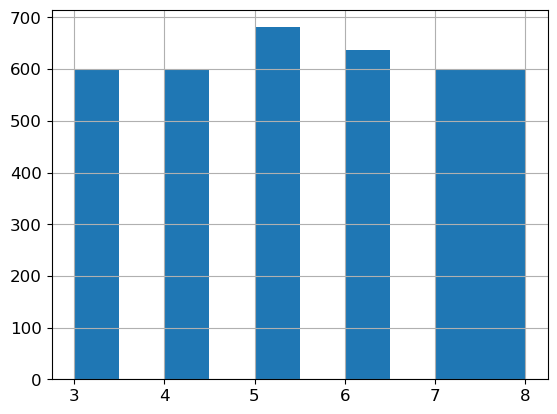

In [286]:
wines_balanced['quality'].hist();

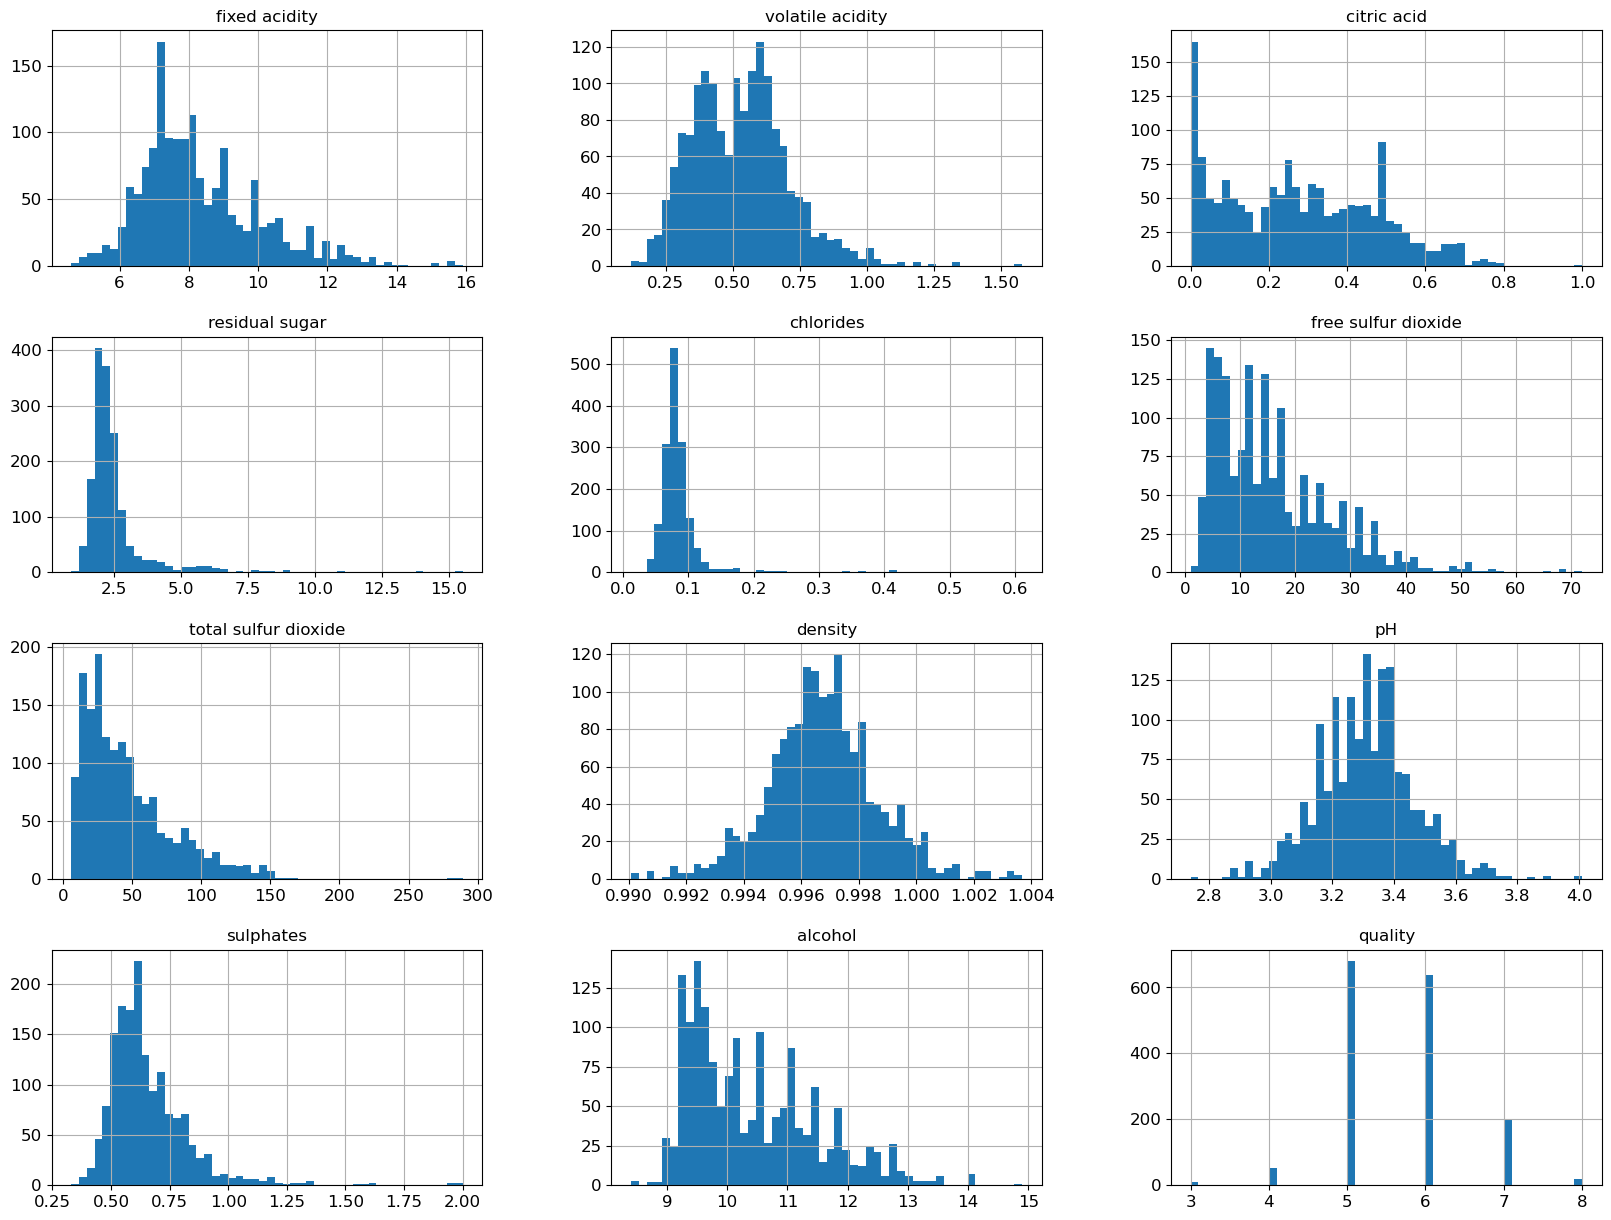

In [198]:
wines.hist(bins=50, figsize=(20,15)) # Histograma
plt.show()

### Buscando correlaciones

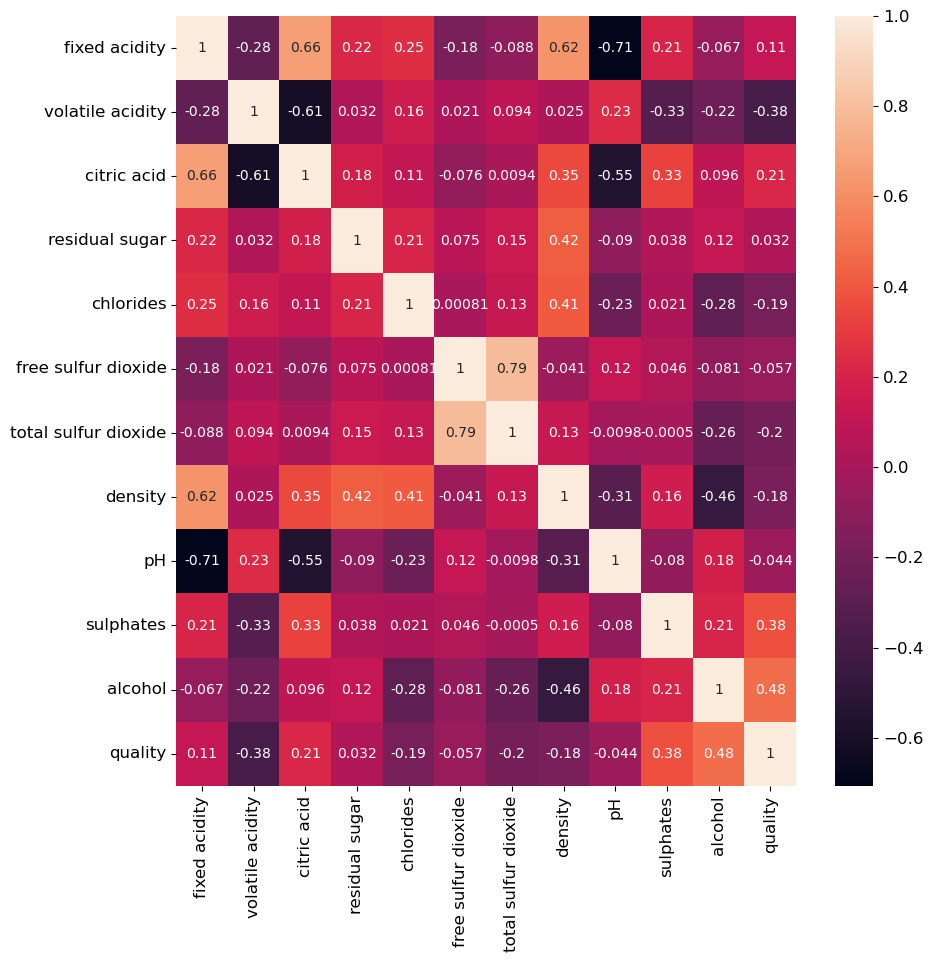

In [199]:
fig, axis= plt.subplots(figsize=(10,10))
sns.heatmap(wines.corr(method="spearman"), annot=True, ax=axis);

##### No hay grandes correlaciones entre la calidad y las demas columnas, pero si es destacable las que hay con:
- Alcoholes = 0.48
- Acidez volatil = -0.395

In [200]:
corr_matrix = wines.corr();
corr_matrix["quality"].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

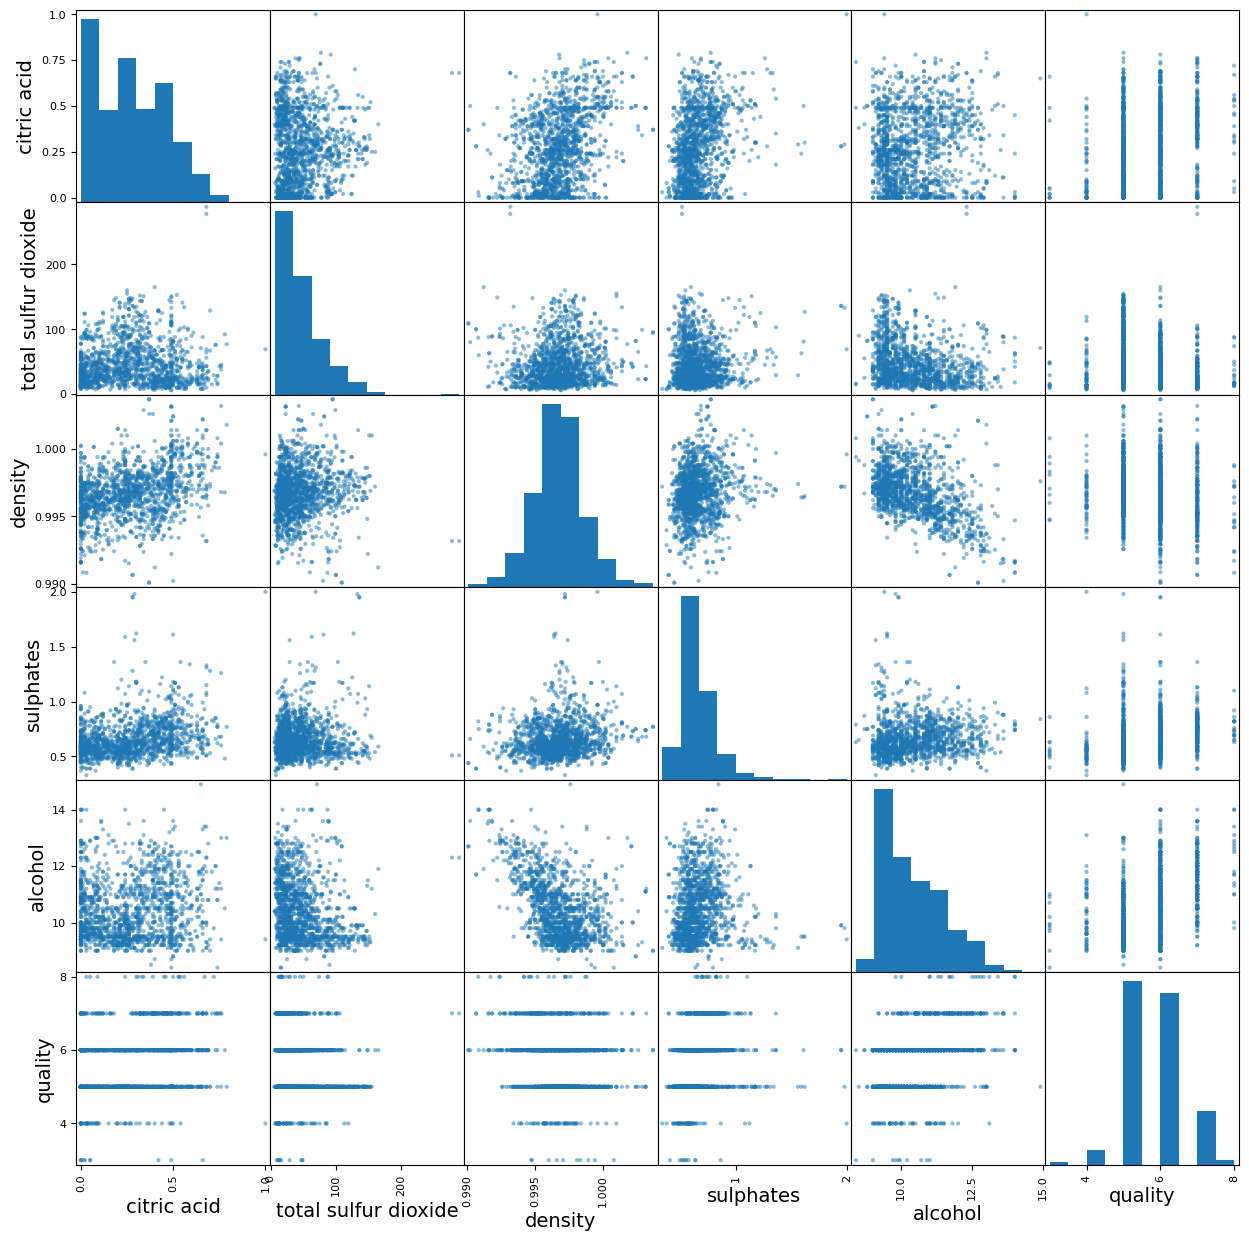

In [201]:
attributes = ['citric acid', 'total sulfur dioxide', 'density',
              'sulphates', 'alcohol', 'quality']


scatter_matrix(wines[attributes], figsize=(15, 15));

### Separando datos de entreno y validacion

- Separamos los datos de entrenamiento y validacion. Utilizamos un 20% del dataset para los datos de validacion, aunque en algunos casos es posible usar el 50%, el 30%...

In [202]:
X_train, X_test = train_test_split(wines, test_size=0.20, random_state=42)
len(X_train), len(X_test)

(1279, 320)

- Guardamos en una variable los datos reales (columna 'quality') y la borramos de la variable de datos de entrenamiento

In [203]:
y_train = X_train["quality"].copy()
X_train = X_train.copy().drop("quality", axis=1)


- Hacemos lo mismo con los datos de validacion

In [204]:
y_test = X_test["quality"].copy()
X_test = X_test.copy().drop("quality", axis=1)

- Ademas guardamos un muestra en una variable para poder obserar las predicciones mas comodamente.

In [205]:
some_data = X_test.sample(3)

### Entrenando modelos

#### *SGDClassifier*:    Se basa en el descenso del gradiente estocastico. Esto lo que proporciona es la minimizacion de la funcion de perdida entre las clases predichas por el clasificador y las clases reales de los datos de entrenamiento.

In [206]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

- Con la siguiente linea podemos ver el total de clases contra las que se clasifica.

In [207]:
sgd_clf.classes_

array([3, 4, 5, 6, 7, 8], dtype=int64)

- Imprimimos las predicciones del set de validacion y vemos que nos devuelve un array de numpy. Este array tiene la misma longitud que el set de validacion y cada posicion indica la clase de calidad a la que pertenece.

In [208]:
sgd_y_pred = sgd_clf.predict(X_test)
print(len(sgd_y_pred))
sgd_y_pred

320


array([5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 7, 5, 5, 6, 5, 4, 5,
       6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 5, 5, 6, 5,
       6, 6, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 6, 5, 6, 5, 5, 6, 5, 5, 6, 5,
       6, 5, 6, 5, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 6, 5, 6,
       6, 5, 5, 5, 6, 6, 5, 6, 5, 6, 5, 5, 5, 5, 5, 4, 6, 6, 6, 5, 5, 5,
       6, 5, 5, 5, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5,
       5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 6, 4, 5, 5, 5, 6, 5, 5,
       5, 5, 5, 6, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5,
       6, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6, 5, 7, 5, 6, 5, 5, 6, 5, 5, 5, 5,
       5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 6, 5, 5, 6, 5,
       5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 7, 6, 6, 6, 6, 5, 5, 5, 6, 5,
       5, 6, 5, 5, 6, 5, 6, 5, 5, 6, 5, 5, 4, 5, 6, 6, 6, 6, 6, 6, 5, 7,
       6, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6,
       5, 5, 5, 5, 5, 7, 5, 5, 5, 6, 5, 7, 6, 6, 5,

- Volvemos a predecir las etiquetas de un set de 3 instancias

In [209]:
sgd_y_pred_muestra = sgd_clf.predict(some_data)
sgd_y_pred_muestra

array([5, 5, 5], dtype=int64)

- Recordamos que las clases/etiquetas qe estamos utilizando para la clasificacion son [3,4,5,6,7,8]
- Utilizando la funcion decision_function() podemos observar la confianza con la que el modelo realizo las predicciones. Podemos ver sobre las dos primeras instancias que solo tiene valores negativos exceptuando el que coincide con la clase 4. En la ultima instancia, sin embargo, la prediccion del modelo obtuvo dos valores positivos cercanos: el perteneciente a la clase 4 (el mas alto) y el perteneciente a la clase 7. Debido a esto es posible que el modelo haya predicho un falso positivo.

In [210]:
sgd_clf.decision_function(some_data)

array([[-305.00641672, -112.59200335,  110.09904802,  -23.18500886,
        -293.95922297, -286.70321811],
       [-568.64232645,  -26.24075137,  391.6475192 ,   -8.14609458,
        -646.33450334, -508.08551491],
       [-574.54149169,  -54.00701612,  317.76897548,    2.59196634,
        -579.65283799, -477.35151462]])

- Vamos a evaluar el modelo con los datos de entrenamiento. Para ello utilizaremos la validacion cruzada, dividieno los datos en 3 subconjuntos y tomando como variable de medida la precision. Entre estos subconjuntos, uno sera para evaluar y el resto para entrenar. Todo esto se hará las veces suficientes para que cada subconjunto haya evaluado una vez.
- Podemos obsevar que la precision no es buena, los distintos subconjuntos rondan entre el 40% y 55%.

In [211]:
scores_sgd = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
f"Precisiones: {scores_sgd}  Media: {scores_sgd.mean()}"

'Precisiones: [0.45433255 0.56103286 0.49530516]  Media: 0.5035568602874075'

1. *Precision*: El porcentaje de aciertos que verdaderamente lo son. En otras palabras, la capacidad del modelo de limitar los falsos positivos.  
   **Precision = TP / (TP + FP)** 
2. *Sensibilidad* (recall): El porcentaje de aciertos que fueron identificados por el modelo.  
   **Recall = TP / (TP + FN)**
3. *F1-score*: Es el promedio ponderado de *recall* y *precision*.  
   **F1-score = 2 * (recall * precision) / (recall + precision)**

In [264]:
precision = precision_score(y_test, sgd_y_pred, average='weighted')
recall = recall_score(y_test, sgd_y_pred, average='weighted')
f1 = f1_score(y_test, sgd_y_pred, average='weighted')

f"Precision: {precision}, recall: {recall}, f1-score: {f1}"

c:\Users\jose.reyarijon\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'Precision: 0.483203125, recall: 0.509375, f1-score: 0.46207175177763415'

#### *SVC*: *Support Vector Machine Classifier* es un clasificador binario (por defecto) que se basa en separar ambas clases por medio de un hiperplano. En el contexto de la clasificacion multiclase, se debera implementar junto con otro clasificador. Los clasificadores que lo pueden acompañar son:
1. *OneVsRestClassifier*
2. *OneVsOneClassifier*

In [213]:
svm_clf = SVC(gamma="auto", random_state=42);

##### *OneVsRestClassifier*: Este clasificador multiclase que entrena un clasificador binario por cada clase, usando los datos de una clase como positivos y los de las demas clases como negativos.

In [214]:
ovr_clf = OneVsRestClassifier(svm_clf);
ovr_clf.fit(X_train, y_train);
ovr_y_pred = ovr_clf.predict(X_test)
ovr_y_pred

array([5, 5, 6, 6, 6, 5, 5, 5, 5, 6, 6, 5, 6, 6, 6, 7, 5, 6, 7, 5, 7, 6,
       7, 7, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 6, 6, 5, 6, 5, 6, 5,
       6, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 6, 6, 5, 6, 6, 5, 5, 6, 5, 6, 6,
       8, 5, 5, 5, 6, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6, 5, 5, 6,
       6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 7, 6, 6, 5, 5, 5, 5,
       6, 5, 5, 5, 6, 6, 7, 6, 5, 6, 5, 6, 6, 5, 5, 5, 6, 5, 5, 6, 6, 5,
       5, 7, 6, 5, 6, 5, 7, 6, 7, 5, 6, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5,
       6, 6, 5, 6, 6, 5, 7, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 6, 6, 5, 5,
       5, 5, 5, 7, 6, 6, 5, 6, 5, 5, 5, 6, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5,
       5, 6, 5, 5, 5, 6, 7, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5,
       5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 5, 6, 7, 6, 5, 6, 5, 6, 5, 5, 6, 5,
       5, 6, 6, 7, 5, 5, 7, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 6, 5, 7,
       5, 6, 5, 5, 6, 6, 6, 6, 6, 6, 5, 5, 6, 7, 5, 6, 7, 5, 5, 5, 5, 7,
       5, 5, 6, 6, 5, 6, 5, 5, 5, 6, 5, 6, 6, 6, 5,

- La precision del modelo SVC con OvR no es mucho mas precisa que la del modelo SGD

In [215]:
scores_ovr = cross_val_score(ovr_clf, X_train, y_train, cv=6, scoring="accuracy")
f"Precisiones: {scores_ovr}  Media: {scores_ovr.mean()}"

'Precisiones: [0.57943925 0.54929577 0.56338028 0.5399061  0.63380282 0.58215962]  Media: 0.5746639755459026'

In [263]:
precision = precision_score(y_test, ovr_y_pred, average='weighted')
recall = recall_score(y_test, ovr_y_pred, average='weighted')
f1 = f1_score(y_test, ovr_y_pred, average='weighted')

f"Precision: {precision}, recall: {recall}, f1-score: {f1}"

c:\Users\jose.reyarijon\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'Precision: 0.49661178315412186, recall: 0.53125, f1-score: 0.5056822605991391'

##### *OneVsOneClassifier*: Este clasificador entrenara las calidades de los vinos entrenando por cada par de claves.

In [217]:
ovo_clf = OneVsOneClassifier(svm_clf);
ovo_clf.fit(X_train, y_train);
ovo_y_pred = ovo_clf.predict(X_test)
ovo_y_pred

array([5, 5, 6, 6, 6, 5, 5, 5, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 5, 5, 6,
       6, 7, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 5,
       6, 5, 6, 6, 5, 6, 5, 5, 6, 5, 5, 6, 6, 5, 6, 6, 5, 6, 6, 5, 6, 6,
       6, 5, 5, 5, 6, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 7, 5, 6, 6, 5, 5, 6,
       6, 5, 6, 5, 5, 6, 5, 6, 5, 6, 5, 6, 5, 5, 6, 7, 6, 6, 5, 5, 5, 5,
       6, 5, 5, 5, 6, 6, 6, 6, 5, 6, 5, 6, 6, 5, 5, 5, 6, 5, 5, 6, 6, 5,
       5, 7, 6, 5, 6, 5, 5, 6, 7, 5, 6, 6, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5,
       6, 6, 5, 6, 6, 6, 7, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 6, 6, 5, 5,
       5, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5,
       6, 6, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5,
       5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 5, 6, 7, 6, 5, 6, 5, 6, 5, 5, 6, 5,
       5, 6, 6, 7, 5, 5, 7, 5, 6, 5, 5, 5, 5, 5, 6, 6, 5, 6, 6, 6, 5, 7,
       5, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 7, 5, 6, 7, 5, 5, 5, 5, 6,
       5, 5, 6, 6, 5, 6, 5, 6, 5, 6, 5, 6, 6, 6, 5,

- Podemos observar que tiene ligeramente mejor precision que el modelo OvR

In [218]:
scores = cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")
f"Precisiones: {scores}  Media: {scores.mean()}"

'Precisiones: [0.55503513 0.55164319 0.55633803]  Media: 0.5543387831542992'

In [262]:
precision = precision_score(y_test, ovo_y_pred, average='weighted')
recall = recall_score(y_test, ovo_y_pred, average='weighted')
f1 = f1_score(y_test, ovo_y_pred, average='weighted')

f"Precision: {precision}, recall: {recall}, f1-score: {f1}"

c:\Users\jose.reyarijon\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'Precision: 0.5029296875, recall: 0.534375, f1-score: 0.5044060871992062'

#### *RandomForestClassifier*: Es un clasificador que se basa en un conjunto de arboles de decision que entrenan submuestras aleatorias.

In [220]:
forest_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
forest_clf.fit(X_train, y_train)
forest_y_pred = forest_clf.predict(X_test)
forest_y_pred

array([5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 7, 5, 6, 5, 5, 6, 5, 6, 7, 5, 5, 6,
       5, 6, 5, 6, 6, 5, 5, 6, 5, 6, 6, 6, 6, 5, 6, 6, 5, 6, 5, 5, 6, 5,
       6, 6, 7, 6, 5, 6, 5, 5, 6, 7, 5, 6, 6, 6, 6, 5, 6, 6, 6, 5, 7, 5,
       7, 6, 7, 5, 6, 5, 6, 6, 6, 5, 7, 5, 6, 7, 5, 7, 5, 6, 6, 6, 5, 6,
       6, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6, 7, 6, 7, 6, 5, 6, 5,
       7, 5, 7, 5, 5, 6, 6, 5, 5, 6, 6, 6, 6, 5, 6, 5, 6, 5, 5, 6, 6, 5,
       5, 6, 6, 5, 5, 5, 5, 6, 7, 6, 7, 6, 6, 5, 6, 6, 6, 5, 6, 6, 5, 5,
       6, 5, 5, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 7, 5, 7, 6,
       6, 5, 5, 5, 5, 6, 5, 6, 5, 7, 6, 6, 7, 5, 6, 6, 5, 6, 6, 5, 5, 6,
       5, 7, 5, 5, 5, 5, 7, 6, 5, 6, 6, 7, 8, 5, 5, 6, 6, 6, 6, 5, 6, 6,
       6, 6, 6, 6, 6, 5, 5, 7, 5, 5, 5, 5, 7, 6, 5, 7, 5, 6, 6, 5, 5, 5,
       6, 7, 5, 7, 6, 6, 6, 5, 6, 6, 5, 6, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6,
       6, 6, 5, 5, 6, 6, 5, 6, 5, 6, 6, 5, 6, 6, 6, 6, 7, 5, 5, 5, 5, 7,
       5, 6, 5, 6, 5, 6, 6, 5, 5, 6, 5, 7, 6, 6, 5,

- Observamos la lista de probabilidades que el *RandomForestClassifier* asigno a cada instancia de cada clase. En la primera lista, por ejemplo, resalta que es mas probable que el vino sea de calidad 5. Aunque hay un pequeña posibilidad de que sea de tipo 4 o 6.

In [221]:
forest_clf.predict_proba(X_test)

array([[0.   , 0.006, 0.737, 0.233, 0.024, 0.   ],
       [0.   , 0.078, 0.703, 0.202, 0.017, 0.   ],
       [0.027, 0.019, 0.582, 0.318, 0.053, 0.001],
       ...,
       [0.002, 0.022, 0.86 , 0.114, 0.002, 0.   ],
       [0.002, 0.002, 0.156, 0.509, 0.298, 0.033],
       [0.013, 0.101, 0.655, 0.224, 0.007, 0.   ]])

In [222]:
scores_forest = cross_val_score(forest_clf, X_train, y_train, cv=6, scoring="accuracy")
f"Precisiones: {scores_forest}  Media: {scores_forest.mean()}"

'Precisiones: [0.6682243  0.6713615  0.68544601 0.66197183 0.73239437 0.76056338]  Media: 0.6966602313778831'

In [261]:
precision = precision_score(y_test, forest_y_pred, average='weighted')
recall = recall_score(y_test, forest_y_pred, average='weighted')
f1 = f1_score(y_test, forest_y_pred, average='weighted')

f"Precision: {precision}, recall: {recall}, f1-score: {f1}"

c:\Users\jose.reyarijon\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'Precision: 0.6279940697646144, recall: 0.659375, f1-score: 0.6410968595275044'

##### *GaussianNB*: El Naive Bayes Classifier es un clasifiador probabilistico basado en el teorema de bayes.

In [224]:
bayes_clf = GaussianNB()  
bayes_clf.fit(X_train, y_train)
bayes_y_pred = bayes_clf.predict(X_test) 
bayes_y_pred

array([5, 5, 6, 5, 6, 5, 5, 5, 6, 6, 7, 5, 6, 5, 5, 7, 5, 6, 7, 5, 5, 5,
       6, 6, 5, 6, 7, 6, 5, 7, 5, 6, 6, 5, 6, 5, 7, 6, 6, 6, 6, 5, 7, 5,
       6, 6, 7, 6, 5, 6, 5, 4, 6, 6, 5, 5, 6, 5, 6, 6, 5, 6, 6, 6, 7, 6,
       7, 6, 7, 5, 7, 5, 6, 6, 6, 5, 7, 5, 6, 7, 6, 7, 5, 6, 6, 7, 5, 6,
       7, 5, 6, 5, 6, 6, 5, 6, 5, 6, 5, 5, 5, 5, 6, 6, 5, 6, 6, 5, 6, 5,
       7, 5, 5, 5, 6, 6, 6, 6, 5, 6, 6, 5, 6, 5, 6, 5, 6, 6, 6, 6, 6, 5,
       5, 7, 6, 5, 5, 5, 5, 6, 7, 6, 6, 6, 6, 5, 6, 5, 6, 5, 6, 6, 5, 6,
       6, 6, 6, 6, 6, 6, 7, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 6,
       6, 5, 5, 4, 5, 7, 5, 7, 5, 7, 5, 6, 7, 5, 5, 7, 6, 7, 6, 6, 5, 5,
       6, 6, 5, 5, 6, 5, 7, 6, 5, 6, 6, 5, 6, 5, 6, 6, 7, 6, 4, 5, 6, 5,
       5, 7, 7, 6, 4, 5, 5, 7, 5, 6, 5, 5, 7, 6, 7, 6, 5, 6, 5, 5, 6, 5,
       6, 7, 4, 6, 6, 5, 8, 5, 6, 6, 5, 5, 3, 5, 5, 6, 6, 7, 7, 6, 5, 7,
       6, 7, 5, 5, 7, 7, 5, 6, 5, 5, 6, 6, 5, 6, 7, 5, 7, 5, 5, 6, 5, 6,
       5, 6, 5, 4, 5, 7, 8, 5, 5, 7, 5, 7, 6, 7, 6,

In [225]:
bayes_clf.predict_proba(X_test)

array([[1.88839460e-03, 9.74404242e-03, 6.46581798e-01, 3.35862485e-01,
        5.92321948e-03, 6.07638853e-08],
       [1.76538422e-07, 2.62591250e-03, 9.41945322e-01, 5.44063786e-02,
        1.01842462e-03, 3.78548665e-06],
       [2.75025827e-04, 6.77597739e-03, 3.78279890e-01, 5.91164996e-01,
        2.34988610e-02, 5.25020592e-06],
       ...,
       [3.06036350e-03, 1.20606457e-02, 6.64847778e-01, 3.14302624e-01,
        5.72856849e-03, 1.96896051e-08],
       [1.43425026e-04, 1.48028019e-03, 3.41569747e-02, 5.14261547e-01,
        4.47927750e-01, 2.03002311e-03],
       [5.07581828e-02, 2.77490958e-02, 7.19697454e-01, 2.00095729e-01,
        1.53406421e-03, 1.65473966e-04]])

In [226]:
scores_bayes = cross_val_score(bayes_clf, X_train, y_train, cv=6, scoring="accuracy")
f"Precisiones: {scores_bayes}  Media: {scores_bayes.mean()}"

'Precisiones: [0.56542056 0.53051643 0.54460094 0.54460094 0.54460094 0.60093897]  Media: 0.5551131294516841'

In [227]:
precision = precision_score(y_test, bayes_y_pred, average='weighted')
recall = recall_score(y_test, bayes_y_pred, average='weighted')
f1 = f1_score(y_test, bayes_y_pred, average='weighted')

f"Pecision: {precision}, recall: {recall}, f1-score: {f1}"

'Pecision: 0.5423266539440204, recall: 0.55, f1-score: 0.5455353196905617'

#### Mejorando las precisiones
- Para mejorar la precision de un modelo es util escalar los datos, es decir, calcular la media y la varianza y aplicarlas al set de entrenamiento y validacion. Esto lo podemos hacer con la clase *StandardScaler*

In [228]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_Scaled = scaler.transform(X_test)

In [248]:
new_scores_sgd = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=4, scoring="accuracy")
f"Precision: {scores_sgd.mean()} --- Precision nueva: {new_scores_sgd.mean()}"

'Precision: 0.5035568602874075 --- Precision nueva: 0.5301356778996865'

In [253]:
new_scores_ovr = cross_val_score(ovr_clf, X_train_scaled, y_train, cv=4, scoring="accuracy")
f"Precision: {scores_ovr.mean()} --- Precision nueva: {new_scores_ovr.mean()}"

'Precision: 0.5746639755459026 --- Precision nueva: 0.6278800940438871'

In [257]:
new_scores_forest = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=4, scoring="accuracy")
f"Precision: {scores_forest.mean()} --- Precision nueva: {new_scores_forest.mean()}"

'Precision: 0.6966602313778831 --- Precision nueva: 0.5301356778996865'

In [260]:
new_scores_bayes = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=6, scoring="accuracy")
f"Precision: {scores_bayes.mean()} --- Precision nueva: {new_scores_bayes.mean()}"

'Precision: 0.5551131294516841 --- Precision nueva: 0.5425862548081845'

### Analisis del error

- Para analizar el error de los modelos anteriores, utilizaremos las matrices de confusion.

In [233]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
cm_sgd = confusion_matrix(y_train, y_train_pred)
cm_sgd 

array([[  1,   0,   7,   1,   0,   0],
       [  0,   0,  31,   9,   3,   0],
       [  4,   1, 464,  65,  17,   0],
       [  1,   0, 318, 151,  36,   0],
       [  1,   0,  62,  66,  28,   0],
       [  0,   0,   1,   8,   4,   0]], dtype=int64)

In [234]:
y_train_pred = cross_val_predict(ovr_clf, X_train, y_train, cv=3)
cm_ovr = confusion_matrix(y_train, y_train_pred)
cm_ovr 

array([[  0,   0,   6,   2,   1,   0],
       [  0,   0,  25,  14,   4,   0],
       [  0,   2, 406, 136,   7,   0],
       [  0,   0, 221, 256,  28,   1],
       [  0,   1,  28,  73,  55,   0],
       [  0,   0,   5,   8,   0,   0]], dtype=int64)

In [235]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)
cm_forest = confusion_matrix(y_train, y_train_pred)
cm_forest 

array([[  0,   1,   6,   2,   0,   0],
       [  1,   0,  29,  12,   1,   0],
       [  0,   1, 444, 103,   3,   0],
       [  0,   0, 133, 340,  33,   0],
       [  0,   0,  14,  82,  61,   0],
       [  0,   0,   0,   5,   6,   2]], dtype=int64)

In [236]:
y_train_pred = cross_val_predict(bayes_clf, X_train, y_train, cv=3)
cm_bayes = confusion_matrix(y_train, y_train_pred)
cm_bayes 

array([[  2,   3,   3,   1,   0,   0],
       [  0,   2,  25,  15,   1,   0],
       [  2,  23, 361, 145,  19,   1],
       [  2,  19, 138, 260,  80,   7],
       [  0,   3,  12,  55,  83,   4],
       [  0,   0,   0,   3,   9,   1]], dtype=int64)

- Podemos observar en la matriz de cofusion del modelo SGD que de las 1087 muestras que se le han pasado para entrenar, 644 han sido TP. Gran parte de estos resultados se concentran en la calidad 5 y 6. Esto era de suponer, ya que nuestro dataset en su gran mayoria esta formado por vinos de esas calidades, es decir, está desbalanceado.
- Destacan tambien los FP que hay en estas dos calidades. tenemos 318 vinos de calidad 6 predichos como vinos de calidad 5. A su vez, tenemos 65 vinos de calidad 5 predichos como vinos de calidad 6.
- Tambien confunde una cantidad considerable de vinos de calidad 7 con los de calidad 6.

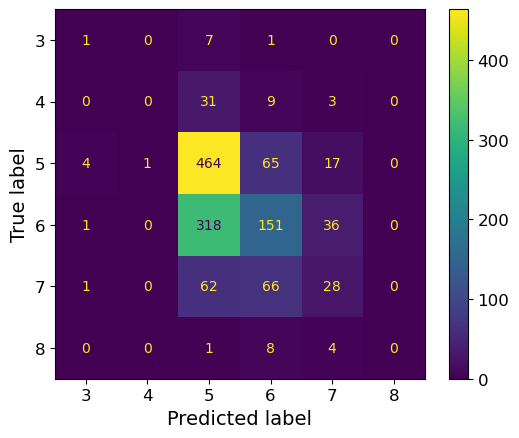

In [237]:
cm_display = ConfusionMatrixDisplay(cm_sgd, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()

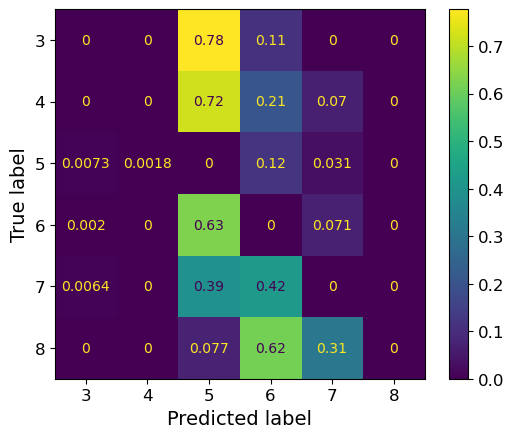

In [238]:

row_sum = cm_sgd.sum(axis=1,keepdims=True)
norm_cm_sgd = cm_sgd / row_sum
np.fill_diagonal(norm_cm_sgd, 0)
cm_display = ConfusionMatrixDisplay(norm_cm_sgd, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()

- La matriz del OvR, en terminos generales, es parecida a la matriz de confusion del modelo SGD.
- Los TP y FP se concentran en las calidades 5 y 6.
- Tambien cabe destacar que la calidad 7 presenta mayor numero de FP y TP.

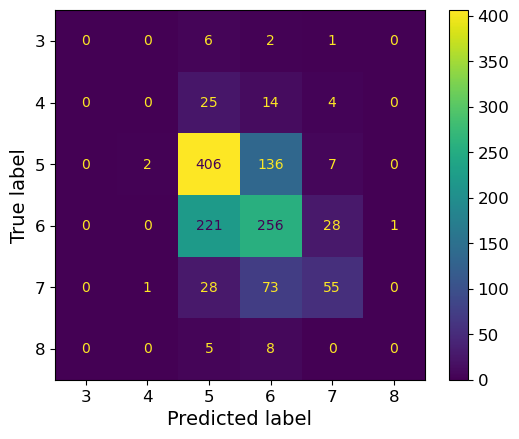

In [239]:
cm_display = ConfusionMatrixDisplay(cm_ovr, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()

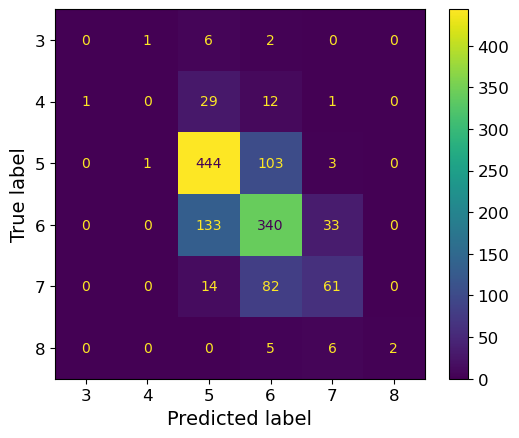

In [240]:
cm_display = ConfusionMatrixDisplay(cm_forest, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()

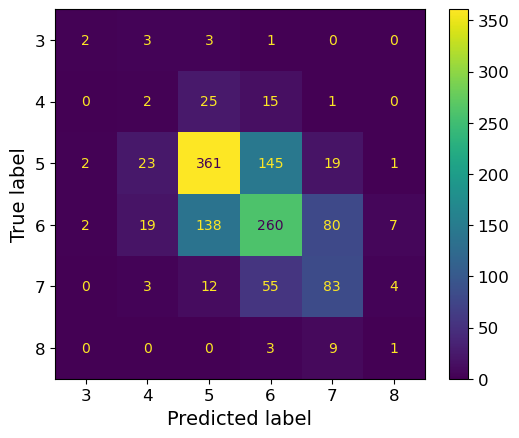

In [241]:
cm_display = ConfusionMatrixDisplay(cm_bayes, display_labels= sgd_clf.classes_)
cm_display.plot()
plt.show()